## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

## Load Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
print("data sizes:")
print("- training:\t{}".format(len(data.train.labels)))
print("- test:\t\t{}".format(len(data.test.labels)))
print("- validation:\t{}".format(len(data.validation.labels))) # wont be used

data sizes:
- training:	55000
- test:		10000
- validation:	5000


### One-Hot Encoding

In [4]:
data.test.labels[0:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [5]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [6]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions

In [7]:
img_size = 28
img_size_flat = img_size**2
img_shape = (img_size, img_size) # used for reshaping arrays
num_classes = 10

### Helper-function for plotting images

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):        
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

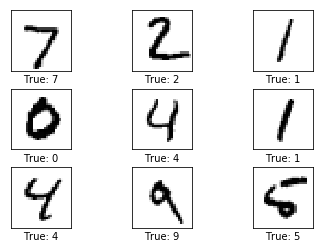

In [9]:
# plot the first 9 imagse
images = data.test.images[0:9]
cls_true = data.test.cls[0:9]
plot_images(images=images, cls_true=cls_true)

### Placeholder variables

In [10]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

In [11]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

In [12]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables to be optimized

In [13]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

In [14]:
biases = tf.Variable(tf.zeros([num_classes]))

### Model

In [15]:
logits = tf.matmul(x, weights) + biases

In [16]:
y_pred = tf.nn.softmax(logits)

In [17]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost-function to be optimized

In [18]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

In [19]:
cost = tf.reduce_mean(cross_entropy)

In [20]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [21]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [22]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Session

In [23]:
session = tf.Session()

In [24]:
session.run(tf.global_variables_initializer())

In [25]:
batch_size = 100

In [26]:
def optimize(num_iterations):
    for i in range(num_iterations):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # run optimizer (gradient descent)
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions to show performance

In [27]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

In [28]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("accuracy: {0:.1%}".format(acc))

In [29]:
def print_confusion_matrix():
    # a confusion matrix helps identify points of confusion for the classifier
    
    cls_true = data.test.cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    matrix = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text
    print(matrix)

    # Plot the confusion matrix as image
    plt.imshow(matrix, interpolation='nearest', cmap='RdPu')

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('predicted')
    plt.ylabel('true')

In [30]:
def plot_example_errors():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    incorrect = (correct == False)
    images = data.test.images[incorrect]
    cls_pred = cls_pred[incorrect]
    cls_true = data.test.cls[incorrect]

    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot the model weights

In [31]:
def plot_weights():
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    fig, axes = plt.subplots(2, 5)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        image = w[:, i].reshape(img_shape)
        ax.set_xlabel("weights ({0})".format(i))
        ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        ax.set_xticks([])
        ax.set_yticks([])

## Testing

### Epochs: 0

In [32]:
print_accuracy()

accuracy: 9.8%


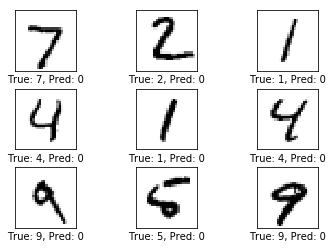

In [33]:
plot_example_errors()

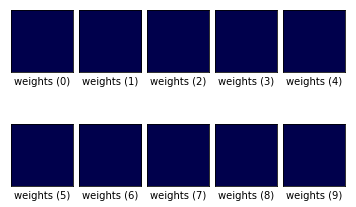

In [34]:
plot_weights()

[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]


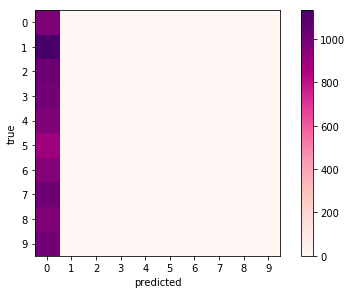

In [35]:
print_confusion_matrix()

### Epochs: 1

In [36]:
optimize(num_iterations=1)

In [37]:
print_accuracy()

accuracy: 25.6%


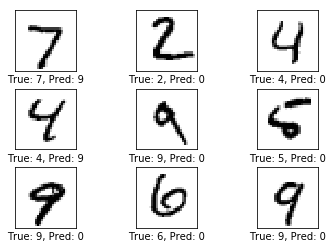

In [38]:
plot_example_errors()

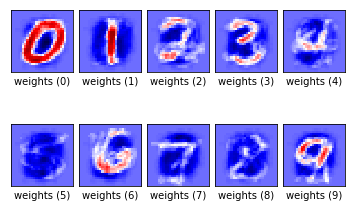

In [39]:
plot_weights()

[[ 980    0    0    0    0    0    0    0    0    0]
 [  39 1035   60    0    0    0    1    0    0    0]
 [ 884   42   67    3    0    0   29    0    0    7]
 [ 906   35    0   59    0    0    0    0    0   10]
 [ 724   61    0    1    0    0    1    0    0  195]
 [ 869   21    0    0    0    0    2    0    0    0]
 [ 780   21    0    0    0    0  157    0    0    0]
 [ 594  119    2    0    0    0    3    0    0  310]
 [ 920   39    0    6    0    0    3    0    0    6]
 [ 644  101    0    1    0    0    1    0    0  262]]


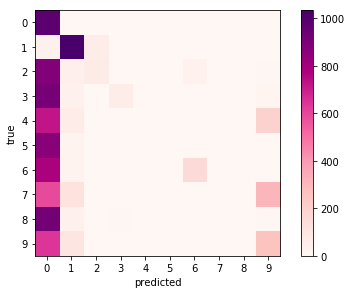

In [40]:
print_confusion_matrix()

### Epochs: 10

In [41]:
optimize(num_iterations=9)

In [42]:
print_accuracy()

accuracy: 76.6%


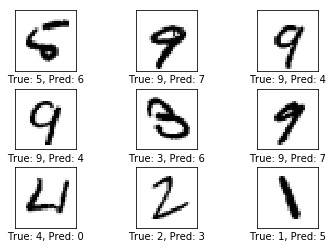

In [43]:
plot_example_errors()

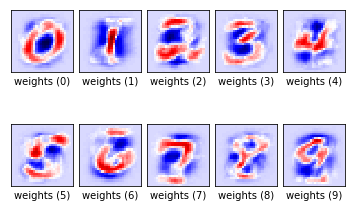

In [44]:
plot_weights()

[[ 921    0    2    0    0   26   29    1    1    0]
 [   0 1048   49    1    1   16    7    1   12    0]
 [  21   12  847    7   23    6   58   36   21    1]
 [  17    2   43  664    0  210   22   48    2    2]
 [   3    5    4    0  890   27   40    4    3    6]
 [  29    4    4   12   22  749   59    8    3    2]
 [  14    4    5    1    3   29  902    0    0    0]
 [   8   19   24    0   19    2    5  941    3    7]
 [  11   28   22   24   21  438   61   51  318    0]
 [  14    7    9    6  294   90   13  189    2  385]]


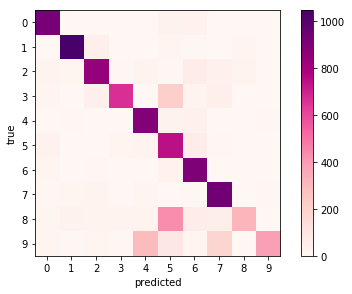

In [45]:
print_confusion_matrix()

### Epochs: 1000

In [46]:
optimize(num_iterations=990)

In [47]:
print_accuracy()

accuracy: 91.7%


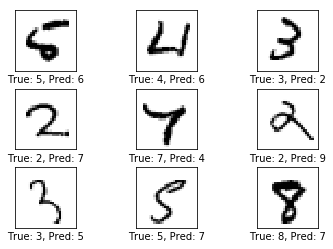

In [48]:
plot_example_errors()

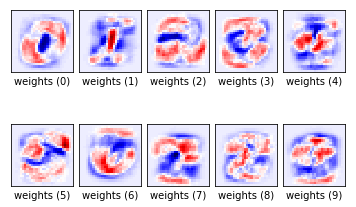

In [49]:
plot_weights()

[[ 963    0    1    1    0    3    9    1    2    0]
 [   0 1109    2    2    0    2    4    2   14    0]
 [  13   11  911   14    8    1   16   14   35    9]
 [   4    1   17  904    0   35    4   15   16   14]
 [   2    1    4    1  884    0   18    3   11   58]
 [  11    3    5   35    8  764   22    9   27    8]
 [  13    3    4    2    8    7  917    2    2    0]
 [   4    7   21    5    7    0    0  950    2   32]
 [  10    8    8   14    8   35   14   15  853    9]
 [  13    5    2   10   21    6    0   27    6  919]]


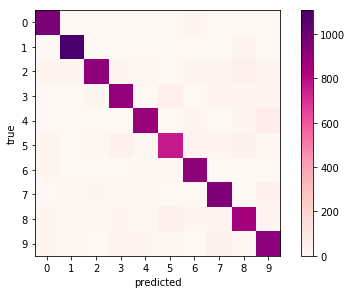

In [50]:
print_confusion_matrix()